# Etapa Flow AI 

## 1 Introdución

Este cuaderno tiene como objetivo explorar y visualizar los metadatos asociados a un conjunto de normativas provenientes de fuentes oficiales. A través de este análisis, se busca identificar patrones relevantes en las características de emisión, periodicidad y clasificación documental.


Este notebook representa la etapa de **análisis exploratorio (EDA)** centrado en los metadatos.

A lo largo del cuaderno se llevarán a cabo los siguientes pasos:
- Combinación y limpieza de archivos fuente (resoluciones, circulares).
- Normalización de campos clave como fuente emisora, fechas y tipo documental.
- Visualización descriptiva de las distribuciones por año, mes, tipo y origen.


In [195]:
# library

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import plotly.express as px
import glob
import os
import re
import unicodedata
from matplotlib.ticker import FuncFormatter


In [ ]:
# -------------------------------
# CONSTANTS
# -------------------------------

DATA_DIR = "./../raw_data"
SUFFIX = ""  # <- Suffix for downloaded files
FILE_NAME = f"01_combined_regulations{SUFFIX}.csv"  # <- Name of the file to be created
OUTPUT_FILE = os.path.join(DATA_DIR, FILE_NAME)

CUSTOM_PALETTE = [
    "#677023",  # Olive Green
    "#F3A7CC",  # Bubblegum Pink
    "#5B6E86",  # Steel Blue
    "#FF5C73",  # Hot Coral
    "#B2A2D6",  # Cool Lilac
    "#DBFF00",  # Neon Lime
    "#FFB300",  # Golden Yellow
    "#212121",  # Deep Charcoal
    "#FEF9ED",  # Light Pink
    "#B4FF00",  # Lime Boots
    "#F9DA00",  # Yellow Suit
    "#DAB9CE",  # Mauve Shadow
    "#FFEDD6",  # Peach Cloud
    "#3D8B84",  # Deep Teal
    "#D1B660"   # Golden Moon
]


In [197]:
# -------------------------------
# FUNCTIONS
# -------------------------------

def clean_file_name(name):
    """
    Cleans and normalizes a file name string by:
    - Converting all characters to lowercase
    - Replacing spaces and special characters with underscores
    - Replacing multiple underscores with a single one
    - Removing leading and trailing underscores
    """
    name = name.lower()
    name = "".join(c if c.isalnum() or c in "_-()" else "_" for c in name)
    name = name.replace(" ", "_")
    name = re.sub(r"[_]+", "_", name)
    name = name.strip("_")
    return name

# Function to load a CSV file and extract metadata
def load_csv(file_path, document_type):
    """
    Loads a CSV file and enriches it with additional metadata:
    - Converts document_type to lowercase
    - Extracts the file origin (base name of the file path)
    - Extracts the year from the 'name' column using a regular expression
    - Applies file name cleaning to the 'name' column

    Parameters:
    - file_path (str): path to the CSV file
    - document_type (str): label to classify the type of document

    Returns:
    - pd.DataFrame: enriched DataFrame with metadata columns
    """
    df = pd.read_csv(file_path)
    df['tipo_documento'] = document_type.lower()
    df['origen'] = os.path.basename(file_path)
    df['anno'] = df['name'].str.extract(r'(\d{4})').astype(int)
    df['nombre_archivo'] = df['name'].apply(clean_file_name)
    return df

def extract_date(text):
    """
    Extracts a date from a string in the format: 'del DD de <month_name> del YYYY'
    and returns it in ISO format (YYYY-MM-DD) if found.
    """
    pattern = r"del (\d{2}) de (\w+) del (\d{4})"
    match = re.search(pattern, text)
    if match:
        day, month_str, year = match.groups()
        month = MONTHS_ES.get(month_str)
        if month:
            return f"{year}-{month}-{day}"
    return None

def make_autopct(values):
    """
    Returns a formatting function for pie chart labels that shows both
    the percentage and the absolute count of each slice.

    Parameters:
    - values (list or array-like): The raw counts corresponding to the pie slices.

    Returns:
    - function: A formatter function to be passed to matplotlib's `autopct` argument.
    """
    def my_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}% ({count})'
    return my_autopct

def analyze_sources_sii(csv_path):
    """
    Cleans and analyzes the 'source' column from an SII regulatory CSV file.
    Prints the top 10 sources and displays a bar chart.

    Parameters:
    -----------
    csv_path : str
        Path to the CSV file (e.g., f'{DATA_DIR}/combined_regulations.csv')
    """

    df = pd.read_csv(csv_path)

    if 'fuente' not in df.columns:
        raise ValueError("The 'fuente' column was not found in the file.")

    # -------------------------
    # DESCRIPTIVE ANALYSIS
    # -------------------------
    source_counts = df['fuente'].value_counts()
    print("\nFuentes más frecuentes:\n")
    print(source_counts.head(10))

    # -------------------------
    # BAR CHART (TOP 10)
    # -------------------------
    top_sources = source_counts.head(10).reset_index()
    top_sources.columns = ['fuente', 'cantidad']

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_sources,
        x='cantidad',
        y='fuente',
        hue='fuente',
        dodge=False,
        palette=CUSTOM_PALETTE[:len(top_sources )],
        legend=False
    )
    plt.title("Fuentes más frecuente en documentos SII")
    plt.xlabel("Cantidad de Documentos")
    plt.ylabel("Tipo de Fuente")

    # Add labels to bars
    for i, val in enumerate(top_sources['cantidad']):
        plt.text(val + 1, i, str(val), va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

    # -------------------------
    # COMPLETE DESCRIPTIVE TABLE
    # -------------------------
    df_sources = source_counts.reset_index()
    df_sources.columns = ['fuente', 'Numero de Documentos']
    df_sources['porcentaje'] = 100 * df_sources['Numero de Documentos'] / df.shape[0]
    df_sources['porcentaje'] = df_sources['porcentaje'].round(2)

    return df_sources



# Clean text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-záéíóúñ\s]', '', text)
    return text

# Function to normalize text: removes accents, trims, capitalizes
def normalize_source(text):
    if pd.isnull(text):
        return text  # Leave NaN values unchanged
    text = text.strip().rstrip('.')                          # Trim and remove trailing dot
    text = ''.join(
        c for c in unicodedata.normalize('NFKD', text)
        if not unicodedata.combining(c)                     # Remove diacritics (accents)
    )
    text = ' '.join(text.split())                           # Collapse multiple spaces
    text = text.title()                                     # Capitalize like a title
    return text


## 1.1 Revisión de Fuentes Normativas

Las normativas han sido recolectadas desde el sitio web oficial del Servicio de Impuestos Internos (SII): fueron descargadas los registros entre los años [2020-2025]

🔗 https://www.sii.cl/normativa_legislacion/resoluciones/{anno}/res_ind{anno}.html

🔗 https://www.sii.cl/normativa_legislacion/circulares/{anno}/indcir{anno}.html

En esta sección se realiza la carga, unión y procesamiento de los archivos CSV que contienen las normativas descargadas. Estos archivos corresponden a distintas categorías documentales como *resoluciones* y *circulares*.

Las acciones ejecutadas incluyen:
- Carga masiva desde la carpeta `raw_data`.
- Identificación del tipo documental.
- Extracción del año desde el nombre del archivo.
- Limpieza del nombre del archivo para facilitar trazabilidad.
- Normalización del campo `fuente` para consolidar variantes textuales.

El resultado final es un único archivo llamado `combined_regulations.csv`, el cual será utilizado para el análisis gráfico posterior.


In [198]:
# Load CSV files for resolutions and circulars
res_files = glob.glob(os.path.join(DATA_DIR, "resoluciones_*.csv"))
circ_files = glob.glob(os.path.join(DATA_DIR, "circulares_*.csv"))


# Merge all DataFrames

print(f"🔍 Loading {len(res_files)} resolution files and {len(circ_files)} circular files...")

🔍 Loading 6 resolution files and 6 circular files...


In [199]:
dataframes = []
for file_path in res_files:
    dataframes.append(load_csv(file_path, "resolucion"))

for file_path in circ_files:
    dataframes.append(load_csv(file_path, "circular"))

print(f"📂 Found {len(dataframes)} files to merge.")
merged_df = pd.concat(dataframes, ignore_index=True)
  
# -------------------------
# CLEANING THE SOURCE COLUMN
# -------------------------
merged_df['source'] = merged_df['source'].astype(str).str.strip()
merged_df['source'] = merged_df['source'].str.replace(r'^Fuente:\s*', '', regex=True).str.title()
merged_df['source'] = merged_df['source'].apply(normalize_source)

merged_df['fuente'] = merged_df['source'].str.strip()
merged_df['nombre'] = merged_df['name'].str.strip()
merged_df['descripcion'] = merged_df['description'].str.strip()
df_final = merged_df.drop(columns=["source", "description", "name"])

# Save the result to a CSV file
df_final.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')
print(f"✅ Files successfully combined and saved to: {OUTPUT_FILE}")


📂 Found 12 files to merge.
✅ Files successfully combined and saved to: ./../raw_data/combined_regulations.csv


## 1.2 Caracterización de MetaDatos

Los metadatos considerados en este análisis corresponden a atributos comunes entre documentos como:

- Nombre del archivo o resolución
- Tipo de documento (resolución, circular, etc.)
- Año y mes de emisión
- Fuente emisora
- Descripción del contenido



In [200]:
# Load data from CSV
df = pd.read_csv(OUTPUT_FILE)

# Dictionary to map Spanish month names to numeric format (MM)
MONTHS_ES = {
    "Enero": "01", "Febrero": "02", "Marzo": "03", "Abril": "04",
    "Mayo": "05", "Junio": "06", "Julio": "07", "Agosto": "08",
    "Septiembre": "09", "Octubre": "10", "Noviembre": "11", "Diciembre": "12"
}

# Apply date extraction and formatting
df["date"] = df["nombre"].apply(extract_date)
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["year_month"] = df["date"].dt.to_period("M")



### 1.2.1 Visualización de los Metadatos

En esta subsección se presentan visualizaciones gráficas que permiten analizar de forma exploratoria los metadatos asociados a las normativas del SII.

Las variables representadas corresponden a atributos como el tipo de documento, año, mes, fuente emisora y descripción.

Las visualizaciones generadas incluyen:

- **Gráfico de torta por tipo de documento:** muestra la proporción relativa de circulares, resoluciones u otros tipos normativos.
- **Gráfico de barras por año:** permite observar la distribución anual de documentos emitidos.
- **Gráfico de barras por mes:** representa la evolución mensual agregada (`año_mes`) para identificar estacionalidades o aumentos puntuales.
- **Top de fuentes emisoras:** visualización horizontal con las entidades más recurrentes como emisoras normativas.
- **Nube de palabras:** representación visual de los términos más frecuentes en las descripciones de documentos, usando una paleta de colores personalizada y jerarquía de frecuencia.

Estas visualizaciones permiten detectar patrones de publicación, ciclos normativos y focos temáticos en los documentos emitidos.


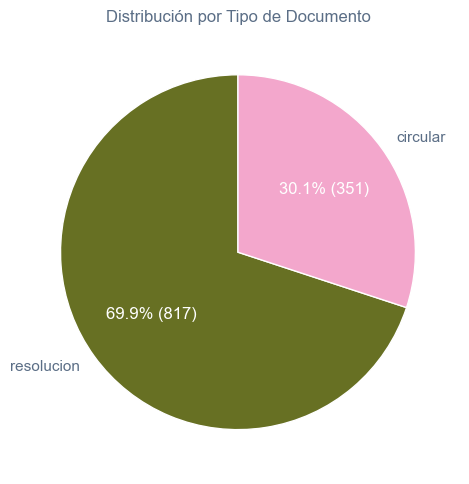

In [201]:
# To display plots inline in Jupyter Notebook
%matplotlib inline

# Set seaborn style and figure size
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# ------------ PIE CHART by Document Type ----------------
doc_type_counts = df['tipo_documento'].value_counts()

plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(
    doc_type_counts.values,
    labels=doc_type_counts.index,
    autopct=make_autopct(doc_type_counts),
    startangle=90,
    colors=CUSTOM_PALETTE[:len(doc_type_counts)],
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)

# Set white color for labels and percentages
for text in texts:
    text.set_color("#5B6E86")
for autotext in autotexts:
    autotext.set_color("white")

plt.title("Distribución por Tipo de Documento", color='#5B6E86')
plt.tight_layout()
plt.show()


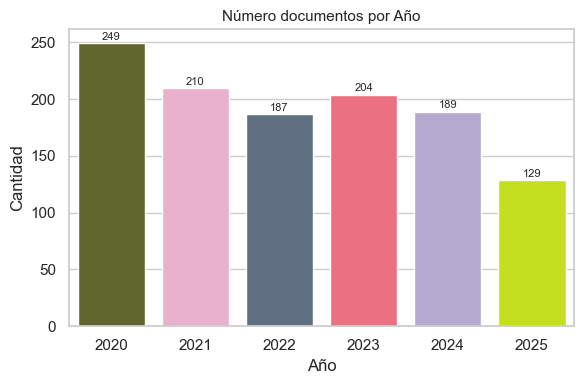

In [202]:
# ------------ BAR CHART: Documents per Year ---------------------
year_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(6, 4))

ax = sns.barplot(
    x=year_counts.index,
    y=year_counts.values,
    hue=year_counts.index.astype(str),  # hue obligatorio si usas palette
    palette=CUSTOM_PALETTE[:len(year_counts)],
    legend=False,

)

# Add values above each bar
for i, value in enumerate(year_counts.values):
    ax.text(i, value + 1, str(value), ha='center', va='bottom', fontsize=8)

plt.title("Número documentos por Año", fontsize=11)
plt.xlabel("Año")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()


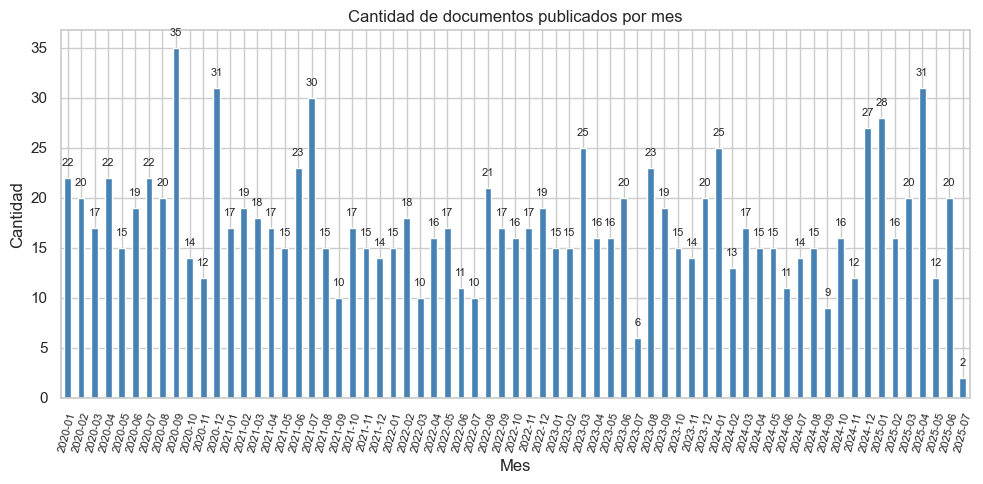

In [203]:
# Para que los gráficos se vean en Jupyter
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
# Convert year_month to string format if not already
df['year_month_str'] = df['year_month'].astype(str)

# Group and sort values by year_month
monthly_counts = df['year_month_str'].value_counts().sort_index()

# Create interactive bar chart

if not monthly_counts.empty:
    plt.figure(figsize=(10, 5))
    ax = monthly_counts.plot(kind='bar', color='steelblue')
    plt.title("Cantidad de documentos publicados por mes")
    plt.xlabel("Mes")
    plt.ylabel("Cantidad")
    plt.xticks(rotation=75, fontsize=8)

    # Añadir texto encima de cada barra
    for i, valor in enumerate(monthly_counts.values):
        plt.text(i, valor + 1, str(valor), ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay datos disponibles para el gráfico mensual.")




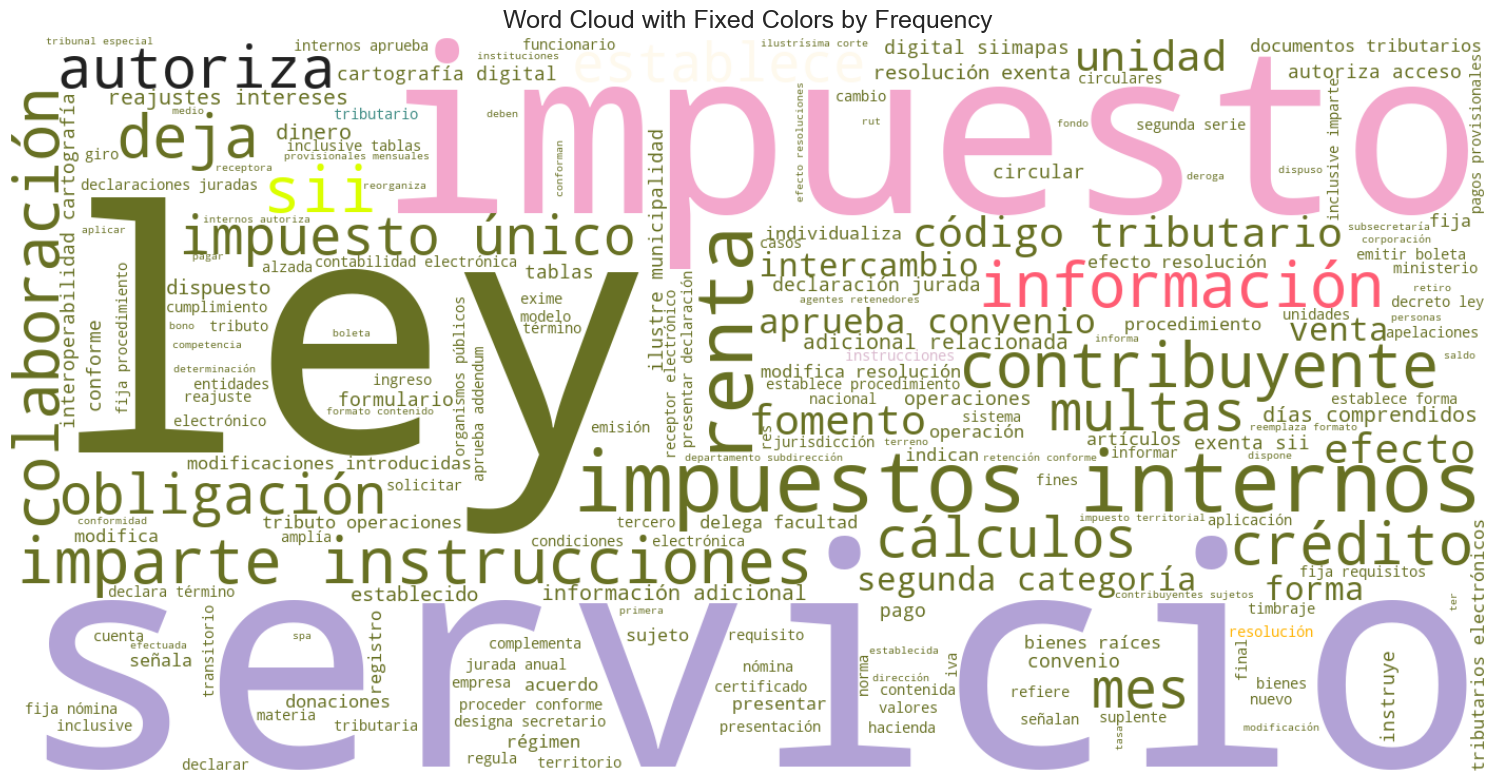

In [204]:

# Path to custom stopwords file
stopwords_path = f"{DATA_DIR}/stopwords.txt"

# Load custom stopwords if available
if os.path.exists(stopwords_path):
    with open(stopwords_path, encoding='latin1') as f:
        custom_stopwords = set(f.read().splitlines())
    stopwords = STOPWORDS.union(custom_stopwords)
else:
    print("⚠️ Custom stopwords file not found. Using default only.")
    stopwords = STOPWORDS



text_corpus = " ".join(df['descripcion'].dropna().astype(str).map(clean_text))

# ----------------------
# COLOR MAPPING SETUP
# ----------------------
words = text_corpus.split()
filtered_words = [w for w in words if w not in stopwords]
word_freq = Counter(filtered_words)

# Assign color to top N words based on CUSTOM_PALETTE
N = len(CUSTOM_PALETTE)
most_common_words = [word for word, _ in word_freq.most_common(N)]
WORD_COLOR_MAP = dict(zip(most_common_words, CUSTOM_PALETTE))

def color_by_word(word, font_size, position, orientation, random_state=None, **kwargs):
    WORD_COLOR_MAP = dict(zip(most_common_words, CUSTOM_PALETTE))
    return WORD_COLOR_MAP.get(word.lower(), "#677023")  # Default olive green for unassigned

# ----------------------
# GENERATE WORD CLOUD
# ----------------------
wordcloud = WordCloud(
    width=1400,
    height=700,
    background_color='white',
    stopwords=stopwords,
    colormap='viridis',
    max_words=200
).generate(text_corpus)

wordcloud.recolor(color_func=color_by_word)

# ----------------------
# PLOT
# ----------------------
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud with Fixed Colors by Frequency", fontsize=18)
plt.tight_layout()
plt.show()



Fuentes más frecuentes:

fuente
Subdireccion De Fiscalizacion                                 359
Subdireccion De Asistencia Al Contribuyente                   219
Subdireccion Normativa                                        203
Subdireccion De Gestion Estrategica Y Estudios Tributarios    117
Subdireccion Juridica                                          78
Subdireccion De Avaluaciones                                   72
Oficina De Gestion Normativa                                   25
Subdireccion De Asuntos Corporativos                           12
Subdireccion De Administracion                                 11
Departamento De Asesoria Juridica                              10
Name: count, dtype: int64


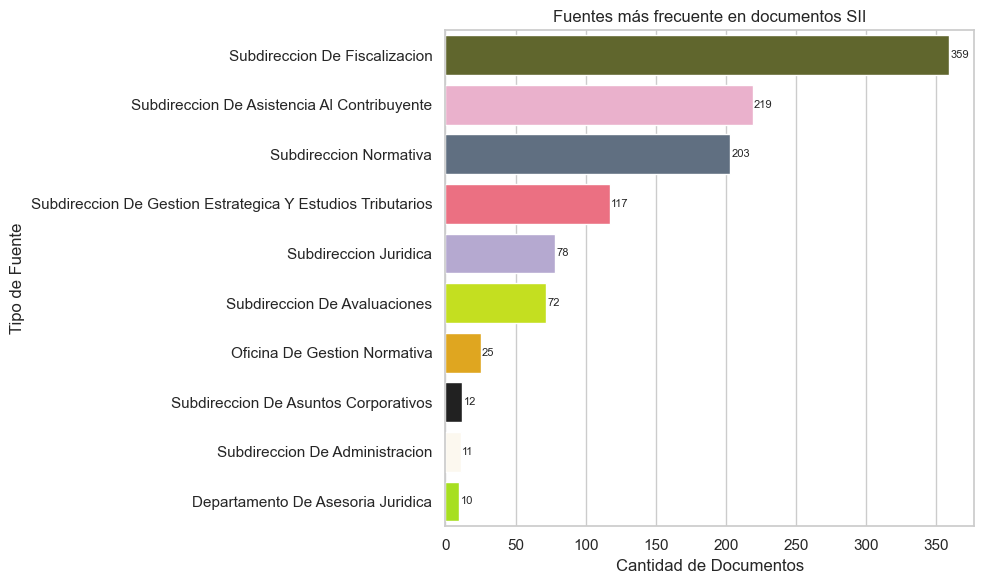

,fuente,Numero de Documentos,porcentaje
0,Subdireccion De Fiscalizacion,359,30.74
1,Subdireccion De Asistencia Al Contribuyente,219,18.75
2,Subdireccion Normativa,203,17.38
3,Subdireccion De Gestion Estrategica Y Estudios...,117,10.02
4,Subdireccion Juridica,78,6.68
5,Subdireccion De Avaluaciones,72,6.16
6,Oficina De Gestion Normativa,25,2.14
7,Subdireccion De Asuntos Corporativos,12,1.03
8,Subdireccion De Administracion,11,0.94
9,Departamento De Asesoria Juridica,10,0.86


In [205]:
analyze_sources_sii(OUTPUT_FILE)

## 1.3 Conclusiones


El presente análisis exploratorio de datos (EDA) permitió consolidar y comprender la estructura de los metadatos asociados a normativas oficiales emitidas por el Servicio de Impuestos Internos (SII), específicamente resoluciones y circulares correspondientes al período 2020-2025. A través de un proceso sistemático de carga, limpieza, normalización y combinación de archivos fuente, se logró generar un dataset unificado, confiable y apto para posteriores análisis cuantitativos o modelado de inteligencia artificial.

El trabajo incluyó el desarrollo de funciones especializadas para la estandarización de nombres y la normalización de campos textuales, asegurando la homogeneidad y trazabilidad de la información. Asimismo, la automatización de la identificación del tipo documental y la extracción de variables clave permitió estructurar adecuadamente los datos y reducir posibles errores derivados de la heterogeneidad de las fuentes originales.

El análisis descriptivo evidenció la presencia de ciertas fuentes emisoras dominantes, lo que aporta información relevante sobre la dinámica documental institucional. Además, la visualización gráfica de la distribución de documentos y la construcción de tablas resumen facilitaron la identificación de patrones y posibles inconsistencias, aspectos esenciales para la mejora de la calidad de los datos.


